<a href="https://colab.research.google.com/github/yaman9675/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

#<b>Import libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

#<b>Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#<b>Import Dataset

In [6]:
# Importing the dataset
nyc_taxi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone Project/NYC Taxi Trip Time Prediction/NYC Taxi Data.csv')

#<b>Data Overview

In [7]:
#View our data set.
nyc_taxi.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [8]:
#Checking number of rows and columns in our dataset.
print("Number of rows is: ", nyc_taxi.shape[0])
print("Number of columns is: ", nyc_taxi.shape[1])

Number of rows is:  1458644
Number of columns is:  11


In [9]:
#Let's look at each feture in our dataset.
nyc_taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [10]:
#Check the number of unique id in our dataset
print(f'We have {nyc_taxi.id.nunique()} unique id in our dataset')

We have 1458644 unique id in our dataset


In [11]:
#Check any NAN/NULL records present in our dataset.
nyc_taxi.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There is no NAN/NULL values in our dataset.

In [12]:
#Let us now look at the datatypes of all features.
nyc_taxi.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [13]:
#We have pickup_datetime, dropoff_datetime of the type 'object'. Convert it into type 'datetime'.
nyc_taxi['pickup_datetime'] = pd.to_datetime(nyc_taxi['pickup_datetime'])
nyc_taxi['dropoff_datetime'] = pd.to_datetime(nyc_taxi['dropoff_datetime'])

In [14]:
nyc_taxi.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


#**Feature Creation**
Now, let us extract and create new features from this datetime features we just created.

In [15]:
nyc_taxi['pickup_weekday']=nyc_taxi['pickup_datetime'].dt.day_name()

nyc_taxi['dropoff_weekday']=nyc_taxi['dropoff_datetime'].dt.day_name()

nyc_taxi['pickup_weekday_num']=nyc_taxi['pickup_datetime'].dt.weekday

nyc_taxi['pickup_hour']=nyc_taxi['pickup_datetime'].dt.hour

nyc_taxi['month']=nyc_taxi['pickup_datetime'].dt.month

We have created the following features:

pickup_weekday which will contain the name of the day on which the ride was taken.
pickup_weekday_num which will contain the day number instead of characters with Monday=0 and Sunday=6.

pickup_hour with an hour of the day in the 24-hour format.

pickup_month with month number with January=1 and December=12.
We saw in our dataset that we have coordinates in the form of longitude and latitude for pickup and dropoff. But, we can’t really gather any insights or draw conclusions from that. So, the most obvious feature that we can extract from this is distance. Let us do that.

Importing the library which lets us calculate distance from geographical coordinates.

In [16]:
from geopy.distance import great_circle

In [17]:
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [18]:
#Finally, applying the function to our dataset and creating the feature ‘distance’.
nyc_taxi['distance'] = nyc_taxi.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

Calculate Speed in km/h for further insights

In [19]:
nyc_taxi['speed'] = (nyc_taxi.distance/(nyc_taxi.trip_duration/3600))

In [20]:
#Let us check the data type of all features.
nyc_taxi.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_weekday                object
dropoff_weekday               object
pickup_weekday_num             int64
pickup_hour                    int64
month                          int64
distance                     float64
speed                        float64
dtype: object

Next, we have defined a function that lets us determine what time of the day the ride was taken.

We have created four parts of time:-

1.**Morning** (from 6:00 am to 11:59 pm),

2.**Afternoon** (from 12 noon to 3:59 pm),

3.**Evening** (from 4:00 pm to 9:59 pm), and

4.**Late Night** (from 10:00 pm to 5:59 am)

In [21]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [22]:
#Now let us apply this function and create new columns in the dataset.
nyc_taxi['pickup_timeofday'] = nyc_taxi['pickup_hour'].apply(time_of_day)

In [23]:
nyc_taxi.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,distance,speed,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,17,3,1.498523,11.856445,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,6,1.805510,9.803673,Late night


Now our dataset is complete for the further analysis before we train our model with optimal variables.

#**Univariate Analysis**
The univariate analysis involves studying patterns of all variables individually.

**Target Variable**

Let us start with the target varibale i.e trip duration.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


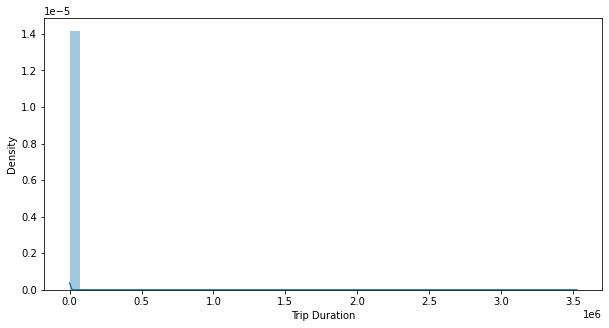

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(nyc_taxi['trip_duration'])
plt.xlabel('Trip Duration')
 
plt.show()

This histogram shows right skewness, hence let's apply the log10 to transform it to the normal distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


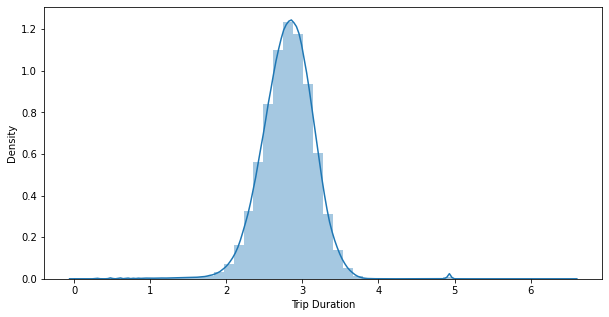

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(np.log10(nyc_taxi['trip_duration']))
plt.xlabel('Trip Duration')
plt.show()

* Here, we can see that trip_duration is normally distributed.
* There are some outliers. Lets see the boxplot of this variable.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


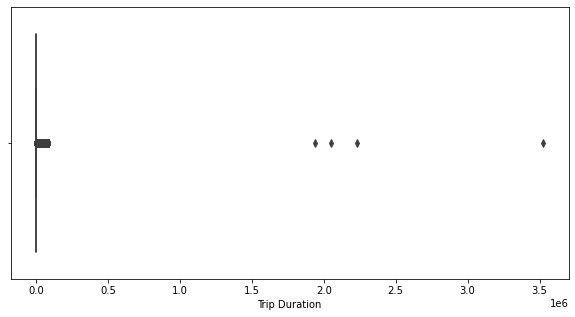

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(nyc_taxi.trip_duration)
plt.xlabel('Trip Duration')
plt.show()

We can clearly see an outlier and should be removed for the data consistency.

Calclating 0-100th percentille to find a correct percentile value for removal of outliers.

In [24]:
for i in range(0,100,10):
  duration= nyc_taxi['trip_duration'].values
  duration= np.sort(duration, axis= None)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ",duration[-1])

0 percentile value is 1
10 percentile value is 245
20 percentile value is 348
30 percentile value is 446
40 percentile value is 548
50 percentile value is 662
60 percentile value is 798
70 percentile value is 968
80 percentile value is 1208
90 percentile value is 1634
100 percentile value is  3526282


The 90th percentile i.e. 1634 looks reasonable. But, 100th percentile i.e. 3526282 is outlier. Hence removing these would be a better idea.

Let's expand from 90th percentile to 100th percentile as to look further for the 99th percentile.

In [25]:
for i in range(90,100):
  duration= nyc_taxi['trip_duration'].values
  duration= np.sort(duration, axis= None)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ",duration[-1])

90 percentile value is 1634
91 percentile value is 1703
92 percentile value is 1780
93 percentile value is 1869
94 percentile value is 1975
95 percentile value is 2104
96 percentile value is 2273
97 percentile value is 2497
98 percentile value is 2829
99 percentile value is 3440
100 percentile value is  3526282


Let's visualize the number of trips taken in slabs of 0-10, 20-30 ... minutes respectively

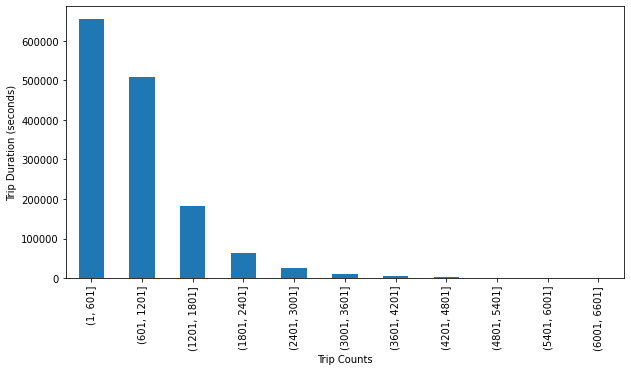

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.trip_duration.groupby(pd.cut(nyc_taxi.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

Let's have a look at the 10 largest and smallest value of trip_duration.

In [26]:
print(nyc_taxi['trip_duration'].nlargest(10))

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64


In [27]:
print(nyc_taxi['trip_duration'].nsmallest(10))

35196     1
207497    1
269418    1
279493    1
285635    1
311745    1
346102    1
346959    1
404610    1
451396    1
Name: trip_duration, dtype: int64


We can see that major chunk (99th percentile) of trip duration is completed in 3440 seconds i.e. nearly 1 hour.

There are very few trip which have duration greater than 5000 seconds.

There are some durations with as low as 1 second. which points towards trips with 0 km distance.

We should get rid the outliers for the sake of data consistency. (Trip duration greater than 5000 seconds and also trip duration less than 30 seconds)

In [28]:
nyc_taxi = nyc_taxi[nyc_taxi.trip_duration <= 5000]
nyc_taxi = nyc_taxi[nyc_taxi.trip_duration >= 30]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


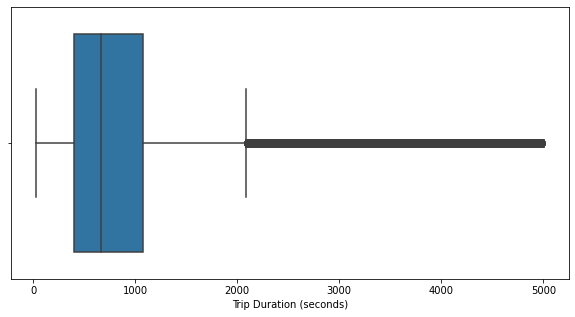

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(nyc_taxi.trip_duration)
plt.xlabel('Trip Duration (seconds)')
plt.show()

* Major trip durations took between 10-20 mins to complete.
* We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs. Let's move ahead to next feature.

<b>Trips per Time of Day

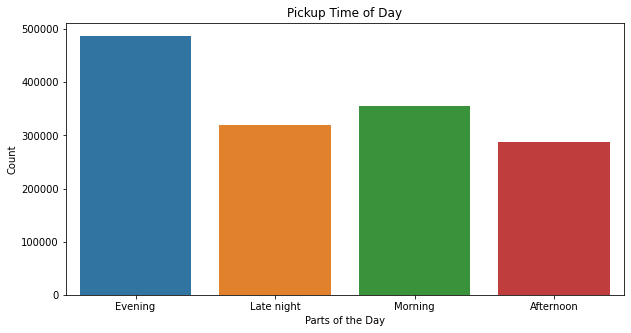

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x="pickup_timeofday",data=nyc_taxi)
plt.title('Pickup Time of Day')
plt.xlabel('Parts of the Day')
plt.ylabel('Count')
plt.show()

As we saw above, evenings are the busiest.

<b>Vendor id

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


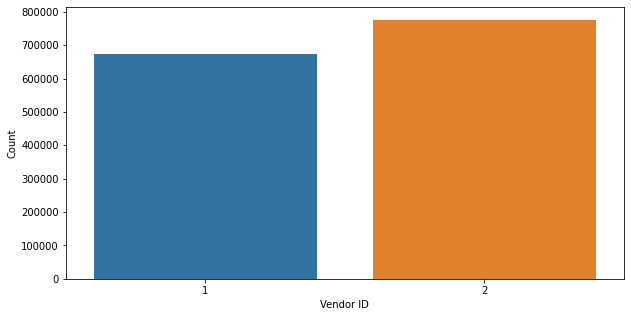

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(nyc_taxi.vendor_id)
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.show()

We see that there is not much difference between the trips taken by both vendors.

<b>Passenger count

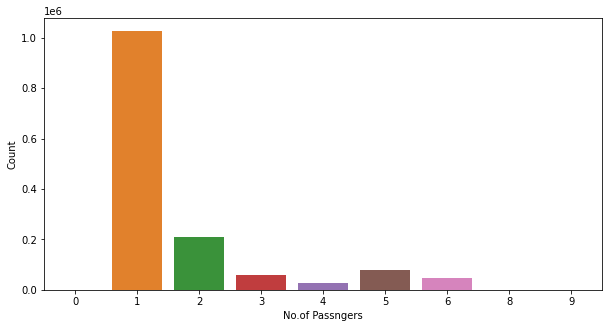

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=nyc_taxi)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()

Let us remove the rows which have 0, 8 and 9 passenger count

In [29]:
nyc_taxi = nyc_taxi[nyc_taxi['passenger_count']!=0]
nyc_taxi = nyc_taxi[nyc_taxi['passenger_count']<=6]

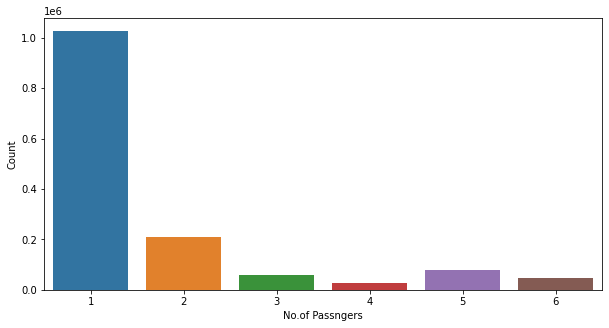

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data = nyc_taxi)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()

* We see the highest amount of trips was taken by a single passenger.
* The instance of large group of people travelling together is rare.

In [ ]:
nyc_taxi.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,distance,speed,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,17,3,1.498523,11.856445,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,6,1.805510,9.803673,Late night


<b>Store and Forward Flag

In [30]:
nyc_taxi['store_and_fwd_flag'].value_counts(normalize=True)

N    0.994549
Y    0.005451
Name: store_and_fwd_flag, dtype: float64

* We can see that only about 1% of the trip details were stored in the vehicle memory first before sending it to the server.

* This might have occured because of the GPS or mobile device battery was down when the trip finished.

<b>Distance

In [31]:
nyc_taxi['distance'].value_counts()

0.000000     4555
0.000424       20
0.000424       12
0.001273        6
0.000424        6
             ... 
0.937296        1
1.057748        1
19.743273       1
0.454561        1
1.134044        1
Name: distance, Length: 1445410, dtype: int64

Let's look at the boxplot.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


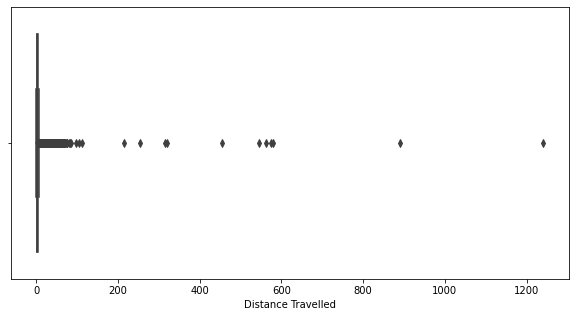

In [32]:
plt.figure(figsize = (10,5))
sns.boxplot(nyc_taxi.distance)

plt.xlabel('Distance Travelled')
plt.show()

* There are some trips with over 100 km distance.
* Some of the trips with 0 km distance.

The possible reasons for 0 km trips can be:

* The dropoff location couldn’t be tracked.
* The driver deliberately took this ride to complete a target ride number.
* The passengers or driver cancelled the trip due to some issue.
* Due to some technical issue in software, etc.

In [33]:
nyc_taxi = nyc_taxi[~(nyc_taxi.distance > 100)]
nyc_taxi = nyc_taxi[~(nyc_taxi.distance < 1)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


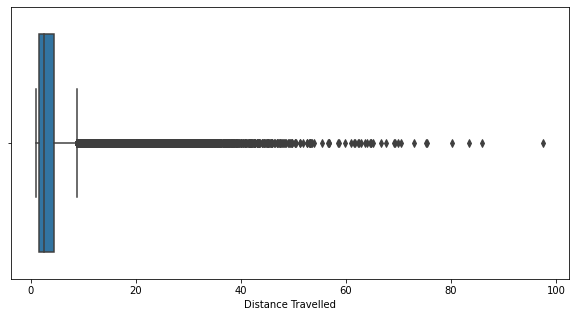

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(nyc_taxi.distance)
plt.xlabel('Distance Travelled')
plt.show()

<b>Speed

In [ ]:
nyc_taxi['speed'].value_counts()

9.580937     2
11.856445    1
24.973027    1
12.398293    1
10.174207    1
            ..
25.772829    1
9.354495     1
19.711113    1
13.742299    1
20.618974    1
Name: speed, Length: 1209265, dtype: int64

In [ ]:
nyc_taxi['speed'].nlargest(10)

906281     1408.106827
693299      583.735137
1359910     564.208013
218935      520.505501
500725      424.861414
473439      356.616642
191997      318.580003
793555      270.595438
1328401     255.419847
176589      226.716083
Name: speed, dtype: float64

Let's plot the boxplot for better understanding.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


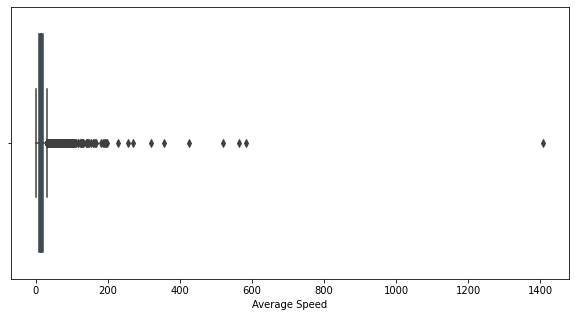

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(nyc_taxi.speed)
plt.xlabel('Average Speed')
plt.show()

There are trips that were done at a speed of over 100 km/h.

As per the rule in NYC, the speed limit is 25 mph(approx. 40km/h) in New York City unless another limit is posted. So having average speed of over 60km/h is quite unreasonable.

In [34]:
nyc_taxi = nyc_taxi[~(nyc_taxi.speed >60)]

Lets take a look at the smallest speeds as well.

In [ ]:
print(nyc_taxi['speed'].nsmallest(10))

1165873    0.777462
24426      0.825900
1025910    0.877407
1440074    0.900916
1453671    0.913801
440689     0.954780
210725     0.962457
985326     0.988256
623249     0.991219
251672     0.998664
Name: speed, dtype: float64


This shows there are speeds which are less than 1 km/hr for a trip which again is quite unreasonable.

In [35]:
nyc_taxi = nyc_taxi[~(nyc_taxi.speed <1)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


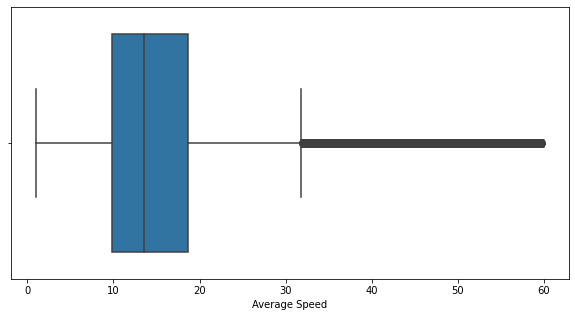

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(nyc_taxi.speed)
plt.xlabel('Average Speed')
plt.show()

Let's take a look at the speed range ditribution with the help of graph.

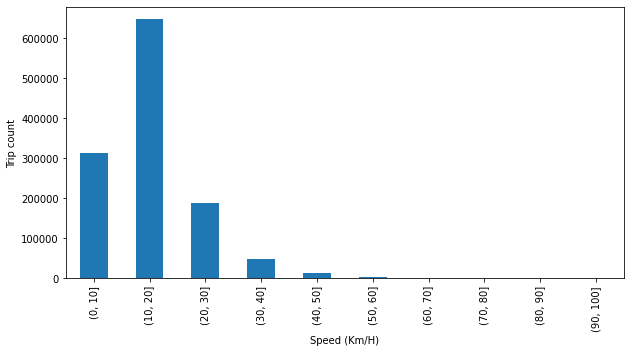

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.speed.groupby(pd.cut(nyc_taxi.speed, np.arange(0,104,10))).count().plot(kind = 'bar')
plt.ylabel('Trip count')
plt.xlabel('Speed (Km/H)')
plt.show()

Mostly trips are done at a speed range of 10-20 km/h.

<b>Trips per hour

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


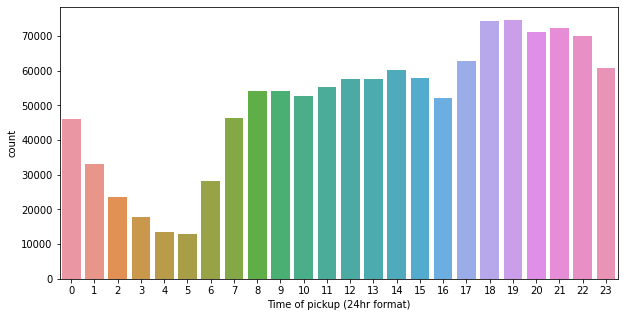

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(nyc_taxi.pickup_hour)
plt.xlabel('Time of pickup (24hr format)')
plt.show()

We see the busiest hours are 6:00 pm to 7:00 pm which makes sense as this is the time for people to return home from work.

<b>Trips per week day

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


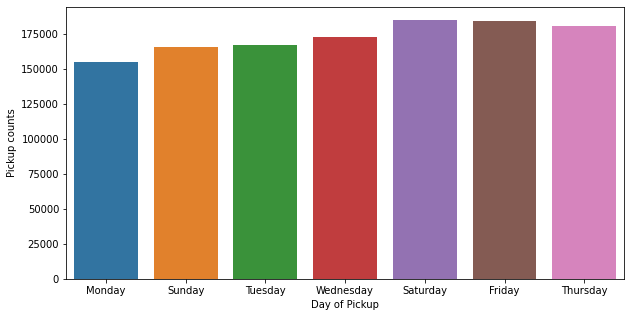

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(nyc_taxi.pickup_weekday)
plt.xlabel('Day of Pickup')
plt.ylabel('Pickup counts')
plt.show()

We see Fridays are the busiest days followed by Saturdays. That is probably because it’s weekend.

<b>Trips per month

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


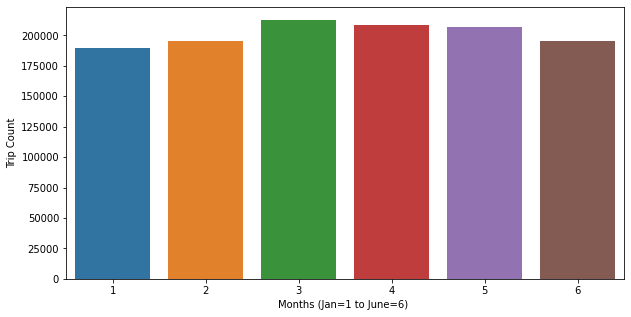

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(nyc_taxi.month)
plt.ylabel('Trip Count')
plt.xlabel('Months (Jan=1 to June=6) ')
plt.show()

There is not much difference in the number of trips across months.

#<b>Bivariate Analysis

Trip Duration per Vendor

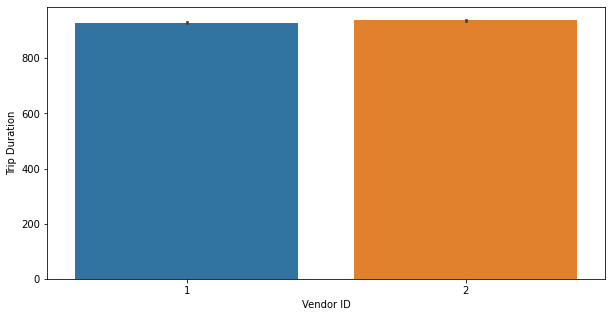

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(y='trip_duration',x='vendor_id',data=nyc_taxi,estimator=np.mean)
plt.xlabel('Vendor ID')
plt.ylabel('Trip Duration')
plt.show()

There is no difference beteen  vendor 1 and 2

<b>Trip Duration per Store and Forward Flagt

<Figure size 720x360 with 0 Axes>

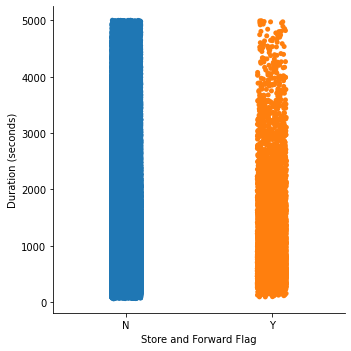

In [ ]:
plt.figure(figsize = (10,5))
sns.catplot(y='trip_duration',x='store_and_fwd_flag',data=nyc_taxi,kind='strip')
plt.xlabel('Store and Forward Flag')
plt.ylabel('Duration (seconds)')
plt.show()

There isn't much difference beteen N and Y i.e.stored flags.

<b>Trip Duration per hour

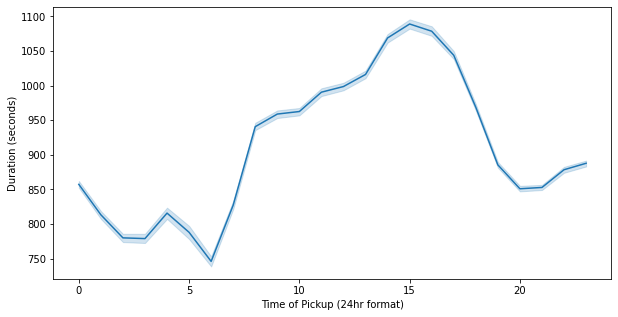

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_hour',y='trip_duration',data=nyc_taxi)
plt.xlabel('Time of Pickup (24hr format)')
plt.ylabel('Duration (seconds)')
plt.show()

* We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.
* Trip duration is the lowest around 6 am as streets may not be busy.

<b>Trip duration per weekday

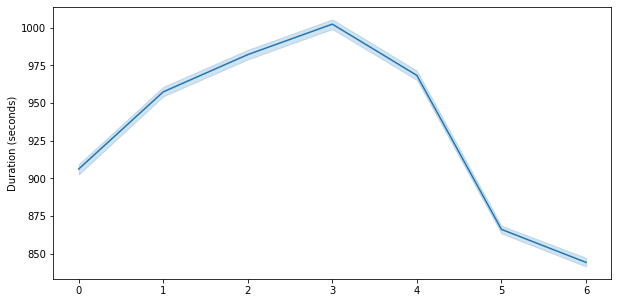

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_weekday_num',y='trip_duration',data = nyc_taxi)
plt.ylabel('Duration (seconds)')
plt.xlabel('')
plt.show()

Trip duration on thursday is longest among all days.


<b>Trip duration per month

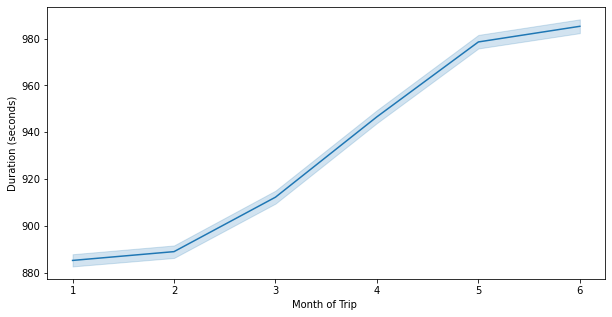

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='month',y='trip_duration', data = nyc_taxi)
plt.ylabel('Duration (seconds)')
plt.xlabel('Month of Trip ')
plt.show()

* From February, we can see trip duration rising every month.
* There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period.


<b>Distance and Vendor

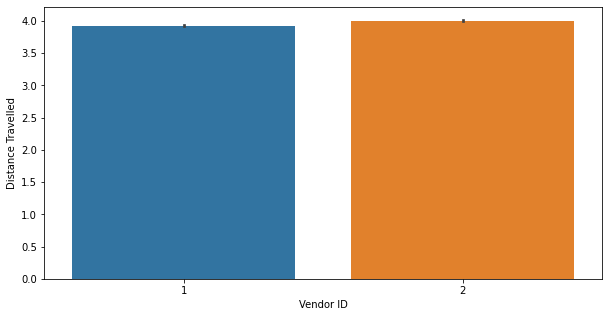

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(y='distance',x='vendor_id',data=nyc_taxi,estimator=np.mean)
plt.ylabel('Distance Travelled')
plt.xlabel('Vendor ID')
plt.show()

The distribution for both vendors is very similar.

<b>Distance and Store and Forward Flag

<Figure size 720x360 with 0 Axes>

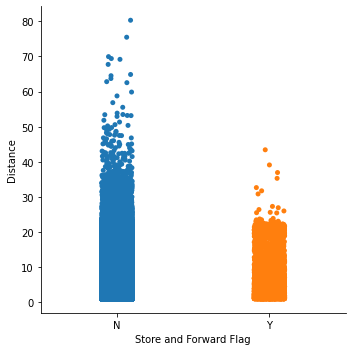

In [ ]:
plt.figure(figsize = (10,5))
sns.catplot(y='distance',x='store_and_fwd_flag',data=nyc_taxi,kind='strip')
plt.ylabel('Distance')
plt.xlabel('Store and Forward Flag')
plt.show()

We see for longer distances the trip is not stored.

<b>Distance and Hour

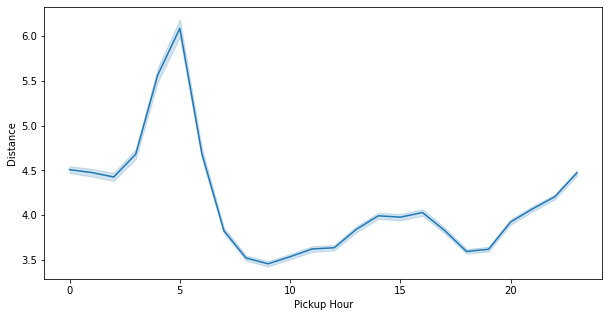

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(y='distance',x='pickup_hour',data=nyc_taxi)
plt.ylabel('Distance')
plt.xlabel('Pickup Hour')
plt.show()

* Trip distance is highest during early morning hours.
* It is fairly equal from morning till the evening varying around 3 - 3.5 kms.
* It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.


<b>Distance per Weekday

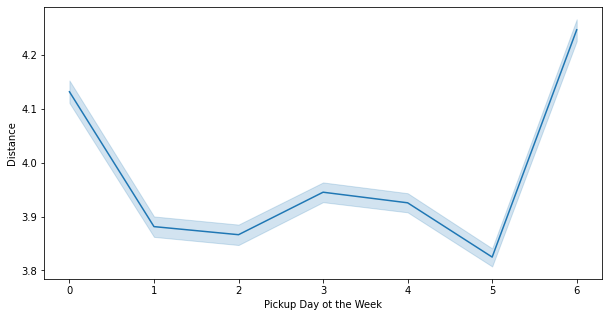

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_weekday_num', y='distance',data=nyc_taxi)
plt.ylabel('Distance')
plt.xlabel('Pickup Day ot the Week')
plt.show()

So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

<b>Distance and Month

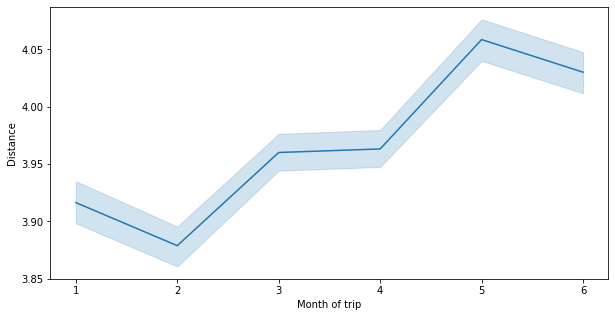

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='month', y='distance',data=nyc_taxi)
plt.ylabel('Distance')
plt.xlabel('Month of trip')
plt.show()

As we already saw during trip duration per month, similarly trip distance is lowest in 2nd month and maximum in 5th month.

<b>Distance and Trip Duration

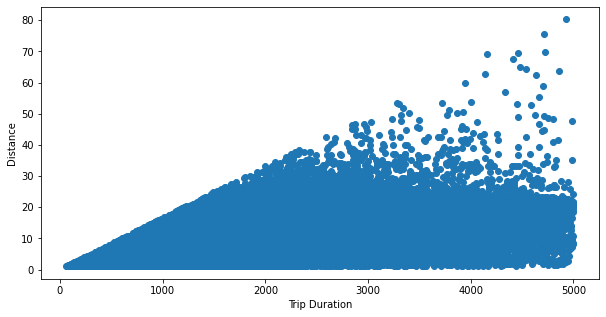

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(x='trip_duration', y='distance',data=nyc_taxi)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

Initially there is some proper correlation between the distance covered and the trip duration in the graph, but later on it seems a little uncorrelated.

We should remove those trips which covered 0 km distance.

In [36]:
nyc_taxi = nyc_taxi[~(nyc_taxi.distance == 0)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


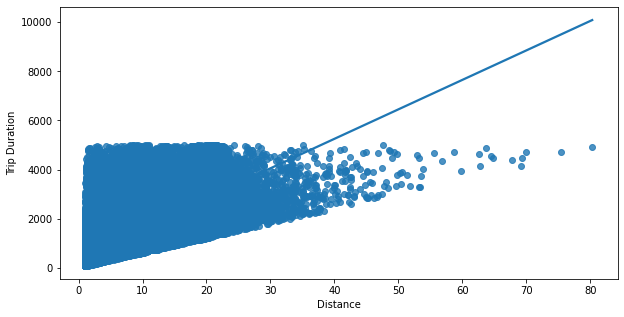

In [ ]:
plt.figure(figsize = (10,5))
sns.regplot(nyc_taxi.distance, nyc_taxi.trip_duration)
plt.ylabel('Trip Duration')
plt.xlabel('Distance')
plt.show()

The straight line shows some linear relation between the two.

#<b>Feature Engineering

**One Hot Encoding**

Dummify features like 'store_and_fwd_flag', and 'pickup_weekday'.

In [37]:
dummy = pd.get_dummies(nyc_taxi.store_and_fwd_flag, prefix='store_and_fwd_flag')
nyc_taxi = pd.concat([nyc_taxi,dummy], axis = 1)

In [38]:
dummy = pd.get_dummies(nyc_taxi.pickup_weekday, prefix='pickup_weekday', drop_first=True)
nyc_taxi = pd.concat([nyc_taxi,dummy], axis = 1,)

Let's convert trip_duration in hours.

In [39]:
nyc_taxi['trip_duration_hour'] = nyc_taxi['trip_duration']/3600

In [40]:
nyc_taxi.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_timeofday,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,trip_duration_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Evening,1,0,1,0,0,0,0,0,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Late night,1,0,0,0,1,0,0,0,0.184167


Let us remove the colmns which are not important for further analysis.

In [41]:
nyc_taxi = nyc_taxi.drop(['id','pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 'pickup_weekday', 'dropoff_weekday', 'pickup_weekday_num', 'pickup_timeofday', 'trip_duration', 'speed'], axis=1)
nyc_taxi.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,month,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,trip_duration_hour
0,2,1,-73.982155,40.767937,-73.964630,40.765602,17,3,1.498523,1,0,1,0,0,0,0,0,0.126389
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6,1.805510,1,0,0,0,1,0,0,0,0.184167
2,2,1,-73.979027,40.763939,-74.005333,40.710087,11,1,6.385108,1,0,0,0,0,0,1,0,0.590000
3,2,1,-74.010040,40.719971,-74.012268,40.706718,19,4,1.485501,1,0,0,0,0,0,0,1,0.119167
4,2,1,-73.973053,40.793209,-73.972923,40.782520,13,3,1.188590,1,0,0,1,0,0,0,0,0.120833


In [42]:
nyc_taxi.shape

(1208841, 18)

In [43]:
nyc_taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1208841 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   vendor_id                 1208841 non-null  int64  
 1   passenger_count           1208841 non-null  int64  
 2   pickup_longitude          1208841 non-null  float64
 3   pickup_latitude           1208841 non-null  float64
 4   dropoff_longitude         1208841 non-null  float64
 5   dropoff_latitude          1208841 non-null  float64
 6   pickup_hour               1208841 non-null  int64  
 7   month                     1208841 non-null  int64  
 8   distance                  1208841 non-null  float64
 9   store_and_fwd_flag_N      1208841 non-null  uint8  
 10  store_and_fwd_flag_Y      1208841 non-null  uint8  
 11  pickup_weekday_Monday     1208841 non-null  uint8  
 12  pickup_weekday_Saturday   1208841 non-null  uint8  
 13  pickup_weekday_Sunday     1

#<b>Correlation Analysis

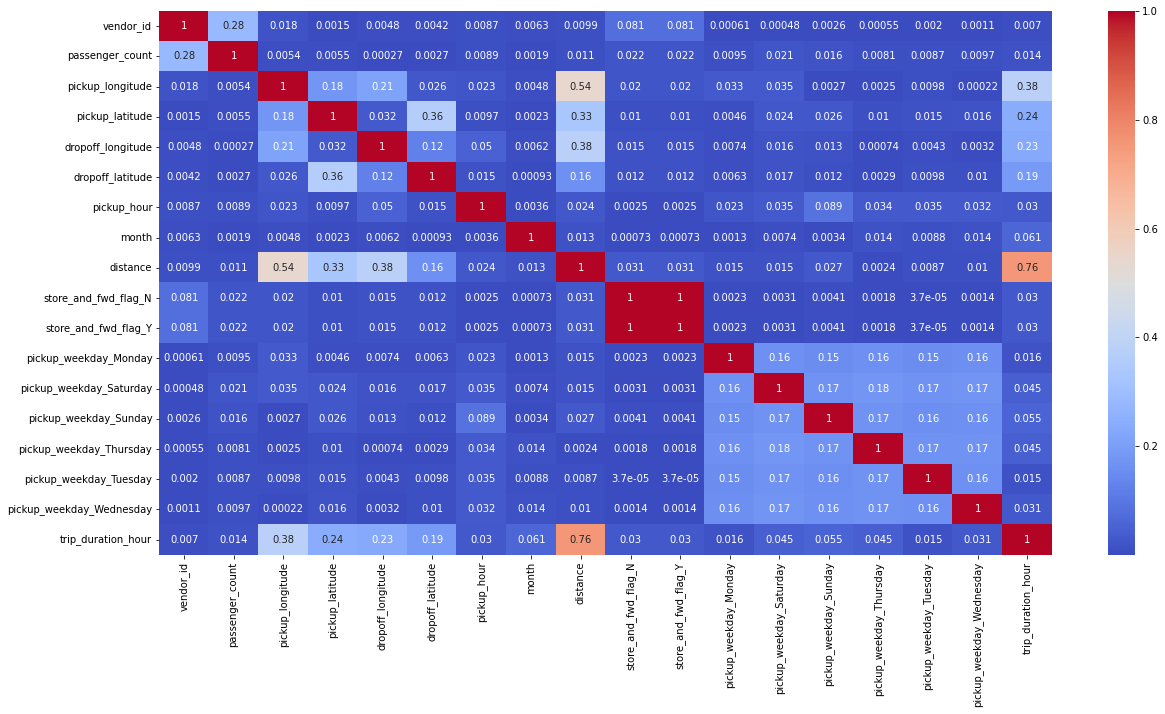

In [ ]:
plt.figure (figsize= (20,10))
corelation= nyc_taxi.corr()
sns.heatmap(abs(corelation), annot=True, cmap='coolwarm')

* We can see store_and_fwd_flag_y and store_and_fwd_flag_N are highly correlated.
* Also they do not affect the target varible i.e. trip_duration_hour much. Hece we should remove these features from our dataset.
* At the same time vendor_id doesn't affect much either so we can remove that as well.

In [44]:
nyc_taxi = nyc_taxi.drop(['store_and_fwd_flag_N', 'store_and_fwd_flag_Y','vendor_id'], axis=1)

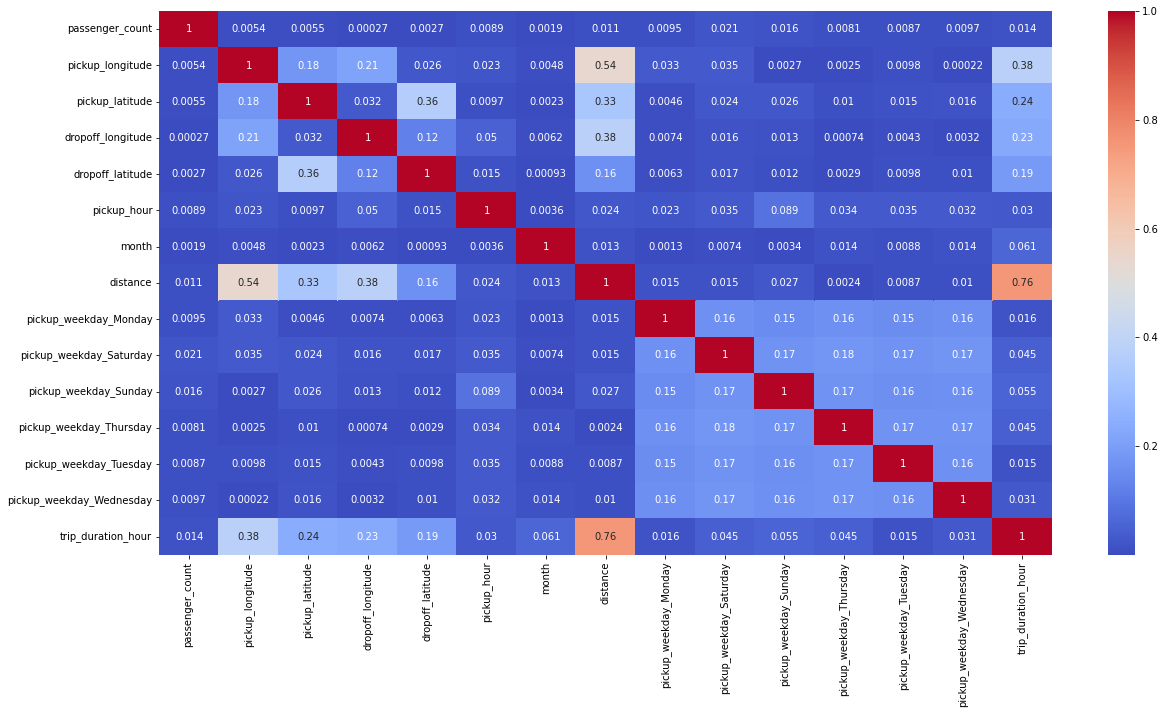

In [ ]:
plt.figure (figsize= (20,10))
corelation= nyc_taxi.corr()
sns.heatmap(abs(corelation), annot=True, cmap='coolwarm')

Let's check numerical features.

In [45]:
numeric_features= nyc_taxi.describe().columns

In [46]:
features= numeric_features.copy()
features= list(features)
features= features[:-1]
features

['passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pickup_hour',
 'month',
 'distance',
 'pickup_weekday_Monday',
 'pickup_weekday_Saturday',
 'pickup_weekday_Sunday',
 'pickup_weekday_Thursday',
 'pickup_weekday_Tuesday',
 'pickup_weekday_Wednesday']

In [47]:
len(features)

14

In [48]:
from scipy.stats import zscore

In [49]:
X = nyc_taxi[features].apply(zscore)[:]  
y= np.log10(nyc_taxi['trip_duration_hour'])[:]

#<b>Splitting the data in train and test sets

In [50]:
#Importing RFE and Linear Regression 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Splited the selected data set in 75-25 split for training and testing purpose respectively

**Recurssive Feature Elimination(RFE)**

RFE tries to select the features that are important and it eliminates the features that are not important.

In [51]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#Running RFE with output number of the variable  equals to 13
lm =  LinearRegression()
rfe = RFE(lm, n_features_to_select=12)
rfe= rfe.fit(X_train, y_train)
#printing the boolean result
rfe.support_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True])

In [52]:
#Assign the rfe features from X_train into col 
col= X_train.columns[rfe.support_]

#<b>Building Model using sklearn

In [53]:
#X_train_rfe is nothing but assigning remaining features after eliminating unimportant features from X_train
X_train_rfe= X_train[col]

In [54]:
import statsmodels.api as sm
#Adding a constant variable
X_train_rfe= sm.add_constant(X_train_rfe)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<b>Running the Linear Model.

In [55]:
lm= sm.OLS(y_train, X_train_rfe).fit()

Let's see the summary of our linear model.

In [56]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     trip_duration_hour   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                 6.849e+04
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        05:06:06   Log-Likelihood:             1.8492e+05
No. Observations:              906630   AIC:                        -3.698e+05
Df Residuals:                  906617   BIC:                        -3.697e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [57]:
X_test.shape

(302211, 14)

#**Making Prediction**

Let's use our model to make prediction.

In [ ]:
#Making prediction
y_pred_train= lm.predict(X_train_rfe)

In [ ]:
X_test_rfe= X_test[col]
#Adding a condtant variable
X_test_rfe= sm.add_constant(X_test_rfe)

#Making prediction
y_pred_test= lm.predict(X_test_rfe)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#**Model Evaluation**

Now, let's check how well our model is able to make prediction.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
lr_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , lr_train_mse)

lr_train_rmse = np.sqrt(lr_train_mse)

print("Train RMSE :" ,lr_train_rmse)

lr_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,lr_train_r2) 

lr_train_r2_ = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lr_train_r2_)

Train MSE : 0.038936965572071804
Train RMSE : 0.19732451842604812
Train R2 : 0.47548270661613623
Train Adjusted R2 :  0.4754746069904877


In [ ]:
lr_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , lr_test_mse)

lr_test_rmse = np.sqrt(lr_test_mse)

print("Test RMSE :" ,lr_test_rmse)

lr_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lr_test_r2)

lr_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_r2_)

Test MSE : 0.039009511747011165
Test RMSE : 0.19750825741475003
Test R2 : 0.4750015172203518
Test Adjusted R2 :  0.47497719532741167


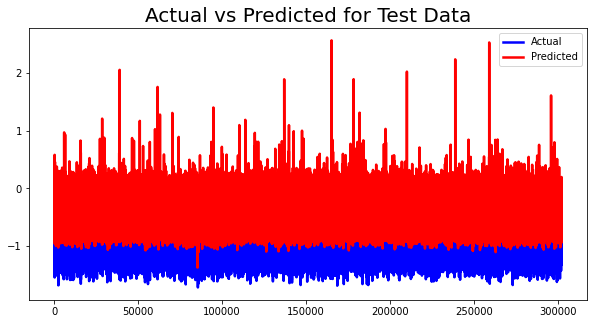

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

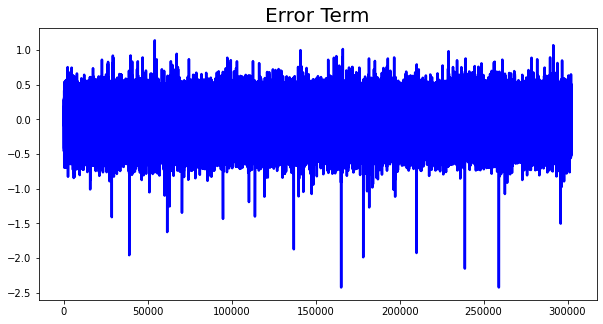

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

As we can clearly see the Linear regression model does not provide us with high accuracy. It has high prediction error on the metrics we tested.

#<b>Running Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
#Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.609e+02, tolerance: 5.390e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+03, tolerance: 5.376e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

**The best parameters for the LASSO Regression which we already tested before to save time when running it again.**
* The best fit alpha value is found out to be : {'alpha': 1e-08}

In [ ]:
lasso_regressor.fit(X_train, y_train)

In [ ]:
print('The best fit alpha value is found out to be :', lasso_regressor.best_params_)
print('The R2 score using the same alpha is :', lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-08}
The R2 score using the same alpha is : 0.47552549860851173


In [ ]:
lasso_regressor.score(X_train, y_train)

0.4755640928302415

In [ ]:
y_pred_lasso_train = lasso_regressor.predict(X_train)
y_pred_lasso_test = lasso_regressor.predict(X_test)

#<b>Model Evaluation

In [ ]:
lasso_train_mse  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , lasso_train_mse)

lasso_train_rmse = np.sqrt(lasso_train_mse)
print("Train RMSE :" ,lasso_train_rmse)

lasso_train_r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,lasso_train_r2)

lasso_train_r2_= 1-(1-r2_score(y_train, y_pred_lasso_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", lasso_train_r2)

Train MSE : 0.038930923955795976
Train RMSE : 0.19730920899896176
Train R2 : 0.4755640928302415
Train Adjusted R2 :  0.4755640928302415


In [ ]:
lasso_test_mse  = mean_squared_error(y_test, y_pred_lasso_test)
print("Test MSE :" , lasso_test_mse)

lasso_test_rmse = np.sqrt(lasso_test_mse)
print("Test RMSE :" ,lasso_test_rmse)

lasso_test_r2 = r2_score(y_test, y_pred_lasso_test)
print("Test R2 :" ,lasso_test_r2)

lasso_test_r2_= 1-(1-r2_score(y_test, y_pred_lasso_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", lasso_test_r2_)

Test MSE : 0.039005133693539494
Test RMSE : 0.1974971738874749
Test R2 : 0.475060438014979
Test Adjusted R2 :  0.47503611885169494


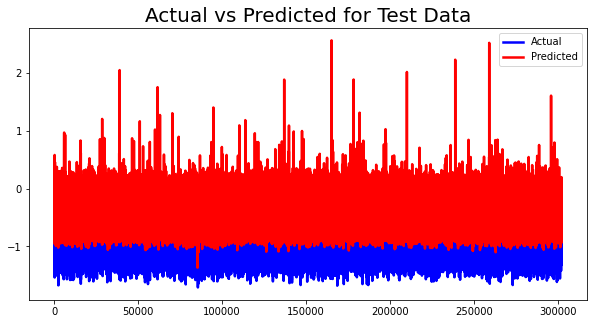

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_lasso_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

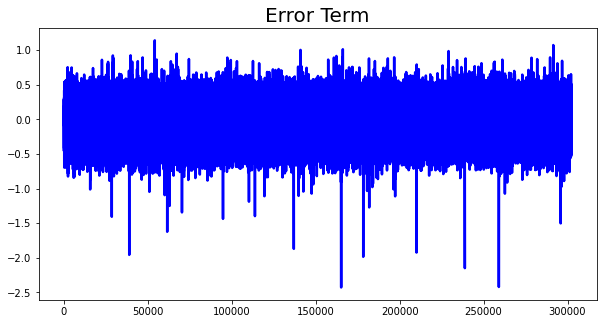

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_lasso_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

The Lasso regresion model doesn't improve on the Linear model either.

#<b>Running Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
#Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

**The best parameters for the RIDGE Regression which we already tested before to save time when running it again.**
* The best fit alpha value is found out to be : {'alpha': 40}

In [ ]:
print('The best fit alpha value is found out to be :' ,ridge_regressor.best_params_)
print('The R2 score using the same alpha is :', lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 40}
The R2 score using the same alpha is : 0.47552549860851173


In [ ]:
ridge_regressor.score(X_train, y_train)

0.4755640902791932

In [ ]:
y_pred_ridge_train=ridge_regressor.predict(X_train)
y_pred_ridge_test = ridge_regressor.predict(X_test)

#<b>Model Evaluation

In [ ]:
ridge_train_mse  = mean_squared_error(y_train, y_pred_ridge_train)
print("Train MSE :" , ridge_train_mse)

ridge_train_rmse = np.sqrt(ridge_train_mse)
print("Train RMSE :" ,ridge_train_rmse)

ridge_train_r2 = r2_score(y_train, y_pred_ridge_train)
print("Train R2 :" ,ridge_train_r2)

ridge_train_r2_= 1-(1-r2_score(y_train, y_pred_ridge_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", ridge_train_r2)

Train MSE : 0.03893092414517025
Train RMSE : 0.1973092094788539
Train R2 : 0.4755640902791932
Train Adjusted R2 :  0.4755640902791932


In [ ]:
ridge_test_mse  = mean_squared_error(y_test, y_pred_ridge_test)
print("Test MSE :" , ridge_test_mse)

ridge_test_rmse = np.sqrt(ridge_test_mse)
print("Test RMSE :" ,ridge_test_rmse)

ridge_test_r2 = r2_score(y_test, y_pred_ridge_test)
print("Test R2 :" ,ridge_test_r2)

ridge_test_r2_= 1-(1-r2_score(y_test, y_pred_ridge_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", ridge_test_r2_)

Test MSE : 0.03900514294841853
Test RMSE : 0.1974971973178823
Test R2 : 0.47506031346080657
Test Adjusted R2 :  0.47503599429175225


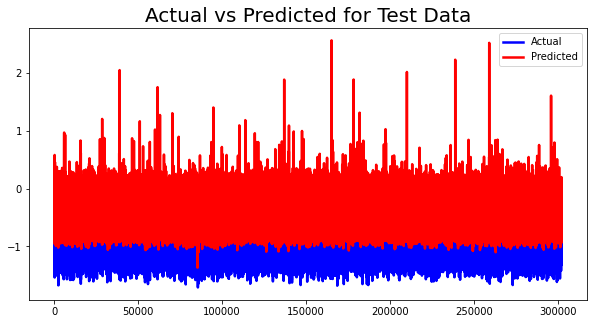

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_ridge_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

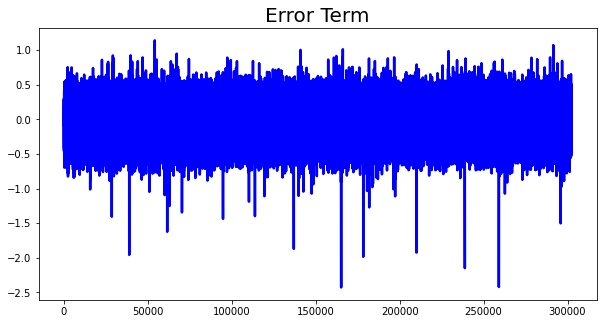

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_ridge_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

The Ridge regresion model doesn't improve on the Linear model either.

#<b>Running Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Maximum depth of trees
max_depth = [4,6,8,10]
 
# Minimum number of samples required to split a node
min_samples_split = [10,20,30]
 
# Minimum number of samples required at each leaf node
min_samples_leaf = [8,16,22]
 
# Hyperparameter Grid
param_dict_dt = {'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

**The best parameters for the Decision Tree Regression which we already tested before to save time when running it again.**
* max_depth=10, min_samples_leaf=22, min_samples_split=10

In [ ]:
param_dict_dt

{'max_depth': [4, 6, 8, 10],
 'min_samples_leaf': [8, 16, 22],
 'min_samples_split': [10, 20, 30]}

In [ ]:
dt = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt,
                       param_grid = cache,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, min_samples_leaf=22, min_samples_split=10; total time=   7.5s
[CV] END max_depth=10, min_samples_leaf=22, min_samples_split=10; total time=   7.3s
[CV] END max_depth=10, min_samples_leaf=22, min_samples_split=10; total time=   9.7s
[CV] END max_depth=10, min_samples_leaf=22, min_samples_split=10; total time=   9.0s
[CV] END max_depth=10, min_samples_leaf=22, min_samples_split=10; total time=   7.2s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10], 'min_samples_leaf': [22],
                         'min_samples_split': [10]},
             scoring='r2', verbose=2)

In [ ]:
dt_grid.best_score_

0.6970678826642874

In [ ]:
dt_grid.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=22, min_samples_split=10)

In [ ]:
y_pred_dt_train=dt_grid.predict(X_train)
y_pred_dt_test=dt_grid.predict(X_test)

#<b>Model Evaluation

In [ ]:
dt_train_mse  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , dt_train_mse)

dt_train_rmse = np.sqrt(dt_train_mse)
print("Train RMSE :" ,dt_train_rmse)

dt_train_r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,dt_train_r2)

dt_train_r2_= 1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", dt_train_r2_)

Train MSE : 0.02214210653085688
Train RMSE : 0.14880223967016384
Train R2 : 0.7017251443006
Train Adjusted R2 :  0.7017205383234435


In [ ]:
dt_test_mse  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , dt_test_mse)
dt_test_rmse = np.sqrt(dt_test_mse)
print("Test RMSE :" ,dt_test_rmse)

dt_test_r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,dt_test_r2)

dt_test_r2_= 1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", dt_test_r2_)

Test MSE : 0.022459722679637206
Test RMSE : 0.1498656821278214
Test R2 : 0.697732173452168
Test Adjusted R2 :  0.69771817012462


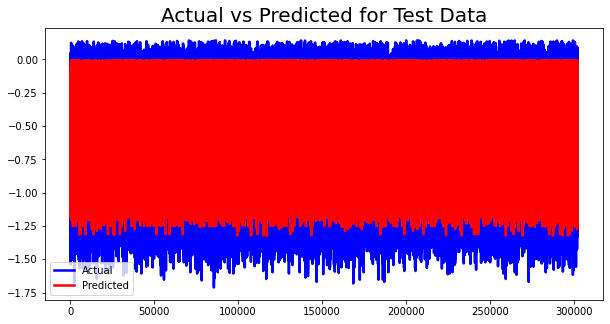

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_dt_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

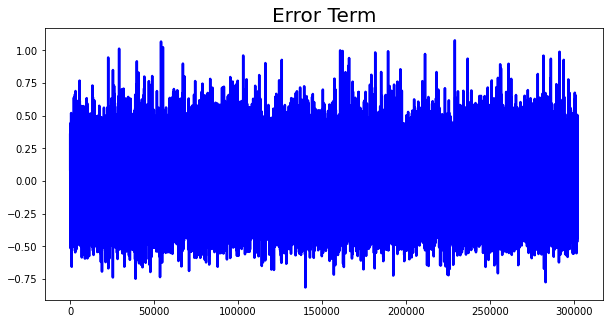

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_dt_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


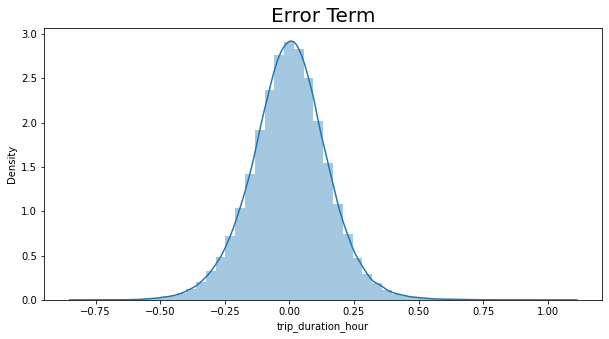

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_dt_test )
plt.title('Error Term', fontsize=20)
plt.show()

The decision tree with the selected hyperparameters does improve the predictions of the model considerably. It still isn't ideal but it is certainly much better than Linear models.

#<b>Running XGBoost Regressor

In [62]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [67]:
xgb_mod = xgb.XGBRegressor()
#grid_values = {'n_estimators' : [80,150,200], 'max_depth': [5,8,10],'min_samples_' : [40,50],'learning_rate' : [0.2,0.4,0.6]}
grid_values = {'n_estimators' : [200], 'max_depth': [8], 'min_samples_' : [40],'learning_rate' : [0.2]}
xgb_model = GridSearchCV(xgb_mod, param_grid = grid_values,scoring = 'r2', cv=5,verbose=1,)

**The best parameters for the XGBoost which we already tested before to save time when running it again.**
* {'learning_rate': 0.2, 'max_depth': 8, 'min_samples_': 40, 'n_estimators': 200}

In [64]:
xgb_model.fit(X_train,y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[05:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, estimator=XGBRegressor(),
             param_grid={'max_depth': [8], 'n_estimators': [2]}, scoring='r2',
             verbose=1)

In [65]:
xgb_model.best_params_

{'max_depth': 8, 'n_estimators': 2}

In [66]:
xgb_model.best_score_

-11.907239147712023

In [ ]:
y_pred_xgb_train=xgb_model.predict(X_train)
y_pred_xgb_test=xgb_model.predict(X_test)

#<b>Model Evaluation

In [ ]:
xgb_train_mse  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , xgb_train_mse)

xgb_train_rmse = np.sqrt(xgb_train_mse)
print("Train RMSE :" ,xgb_train_rmse)

xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,xgb_train_r2)

xgb_train_r2_= 1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", xgb_train_r2_)

Train MSE : 0.5955215467842543
Train RMSE : 0.7717004255436525
Train R2 : -4.854247028428633
Train Adjusted R2 :  -4.85432285215525


In [ ]:
xgb_test_mse  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , xgb_test_mse)

xgb_test_rmse = np.sqrt(xgb_test_mse)
print("Test RMSE :" ,xgb_test_rmse)

xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,xgb_test_r2)

xgb_test_r2_= 1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", xgb_test_r2_)

Test MSE : 0.5942387594757909
Test RMSE : 0.7708688341577903
Test R2 : -4.841597836024708
Test Adjusted R2 :  -4.841824822010449


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


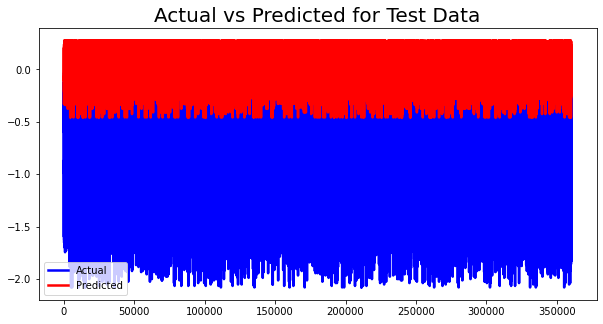

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_xgb_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

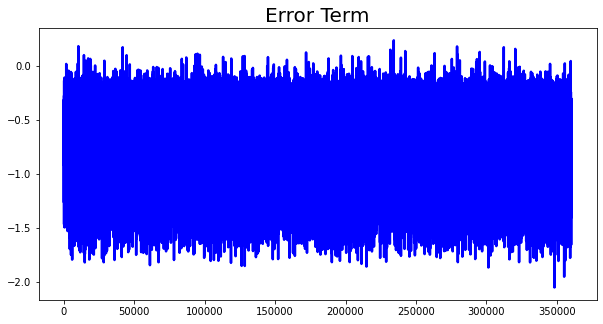

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_xgb_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

Finally, let's also look the feature importance.

In [ ]:
importance_df= pd.DataFrame({'Features': features, 'Feature_importance': list(xgb_mod.best_estimator_.feature_importances_)})
importance_df

,Features,Feature_importance
0,passenger_count,0.000354
1,pickup_longitude,0.003574
2,pickup_latitude,0.001965
3,dropoff_longitude,0.002352
4,dropoff_latitude,0.034139
5,pickup_hour,0.037738
6,month,0.001065
7,distance,0.879231
8,pickup_weekday_Monday,0.006282
9,pickup_weekday_Saturday,0.013846


In [ ]:
importance_df.sort_values(by=['Feature_importance'],ascending=False,inplace=True)

Let's look it by using bar grabh.

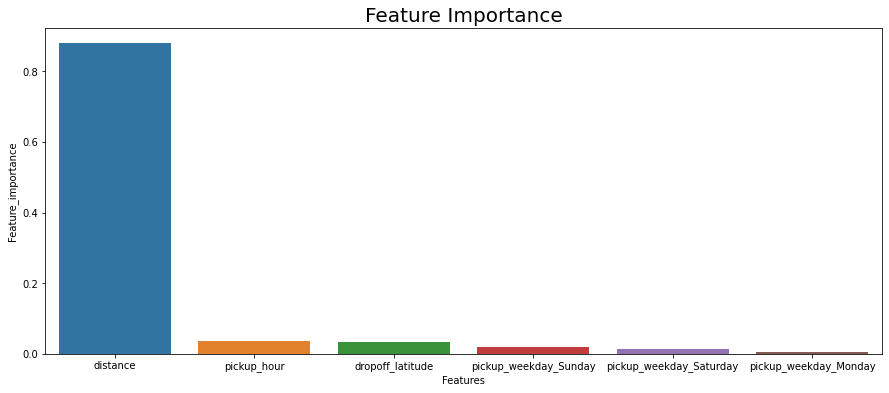

In [ ]:
plt.figure(figsize=(15,6))
plt.title('Feature Importance', fontsize=20)
sns.barplot(x='Features',y="Feature_importance", data=importance_df[:6])
plt.show()

Clearly, we can see distance is the top contributor to trip duration followed by different days of the weeks.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


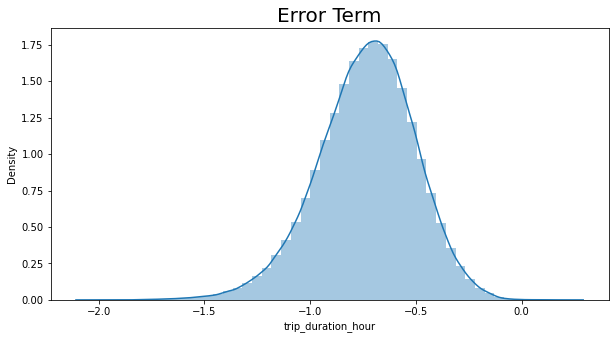

In [ ]:
#Plotting the error terms to understand the distribution.
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_xgb_test )
plt.title('Error Term', fontsize=20)
plt.show()

#<b>Evaluating the models
Models Summary for the Train data.

In [ ]:
models= ['Linear Regression', 'Lasso Regression', 'Ridge Regression','DecisionTree Regressor','XGBoost Regressor']
train_mse= [lr_train_mse, lasso_train_mse, ridge_train_mse, dt_train_mse, xgb_train_mse]
train_rmse= [lr_train_rmse, lasso_train_rmse, ridge_train_rmse, dt_train_rmse, xgb_train_rmse]
train_r2= [lr_train_r2, lasso_train_r2, ridge_train_r2, dt_train_r2, xgb_train_r2]
train_adjusted_r2= [lr_train_r2_, lasso_train_r2_, ridge_train_r2_, dt_train_r2_, xgb_train_r2_]

<b>Models Summary for the test data.

In [ ]:
models= ['Linear Regression', 'Lasso Regression', 'Ridge Regression','DecisionTree Regressor','XGBoost Regressor']
test_mse= [lr_test_mse, lasso_test_mse, ridge_test_mse, dt_test_mse, xgb_test_mse]
test_rmse= [lr_test_rmse, lasso_test_rmse, ridge_test_rmse, dt_test_rmse, xgb_test_rmse]
test_r2= [lr_test_r2, lasso_test_r2, ridge_test_r2, dt_test_r2, xgb_test_r2]
test_adjusted_r2= [lr_test_r2_, lasso_test_r2_, ridge_test_r2_, dt_test_r2_, xgb_test_r2_]

In [ ]:
Train_data_df=pd.DataFrame({'Model Name': models, 'Train MSE': train_mse, 'Train RMSE': train_rmse, 'Train R^2': train_r2, 
                            'Train Adjusted R^2': train_adjusted_r2})
Train_data_df

In [ ]:
Test_data_df= pd.DataFrame({'Model Name': models, 'Test MSE': test_mse, 'Test RMSE': test_rmse, 'Test R^2': test_r2, 
                            'Test Adjusted R^2': test_adjusted_r2})
Test_data_df

#**Conclusion**
* We can see that MSE and RMSE which are the metrics used to evaluate the performance of regression model of **Decision Tree** and **XGBoost Regressor** is not varying much during traing and testing time. Also the R^2 is about same during training and Testing time.
* The Linear models don't show good performance on our training and testing environment.
* From above table we can conclude that **XGBoost Regressor** is the best models as compare to the other models to predict the trip duration for a particular taxi.